# Вариант 1-05

---

Линейная регрессия:

$$ h(x) = \tilde{y}(x) = \beta_0 + \beta_1 x $$

Lasso:

$$ \tilde{\beta} = \arg \min \left( \sum_i (y_i - \tilde{y}_i)^2 +\lambda (|\beta_0| + |\beta_1|) \right) $$

---

## Считываем и обрабатываем выборку

300


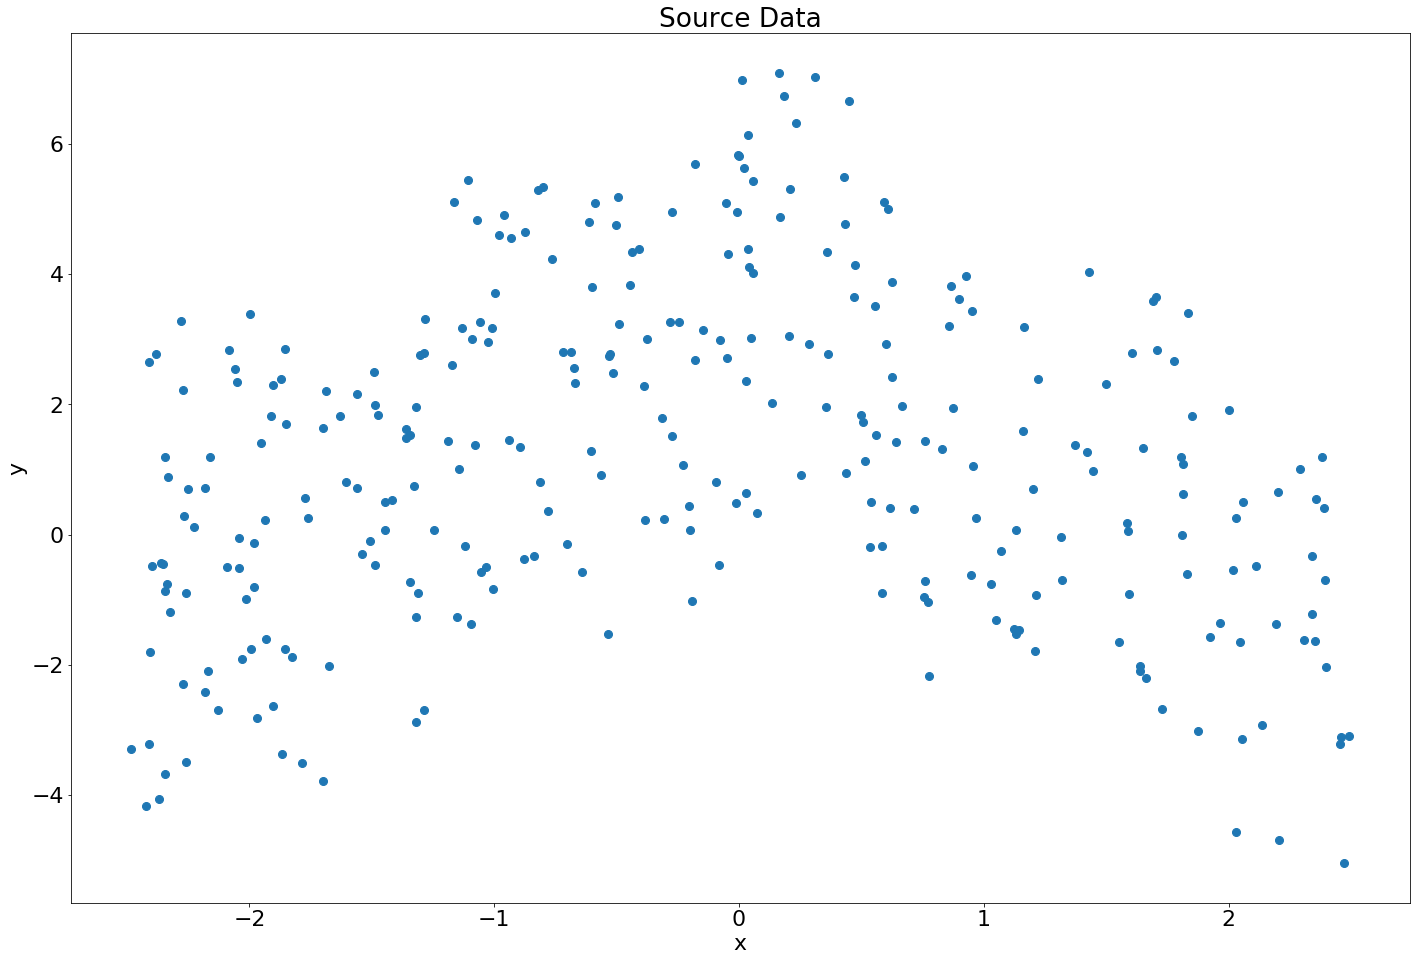

In [132]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split

pylab.rcParams['figure.figsize'] = (24.0, 16.0)
plt.rcParams.update({'font.size': 22})

data = pd.read_csv("data.csv")
sample = data.values
x = sample[:, 0]
y = sample[:, 1]

plt.title('Source Data')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x, y, 'o', markersize=8)

print(len(x))

## Нормализуем данные

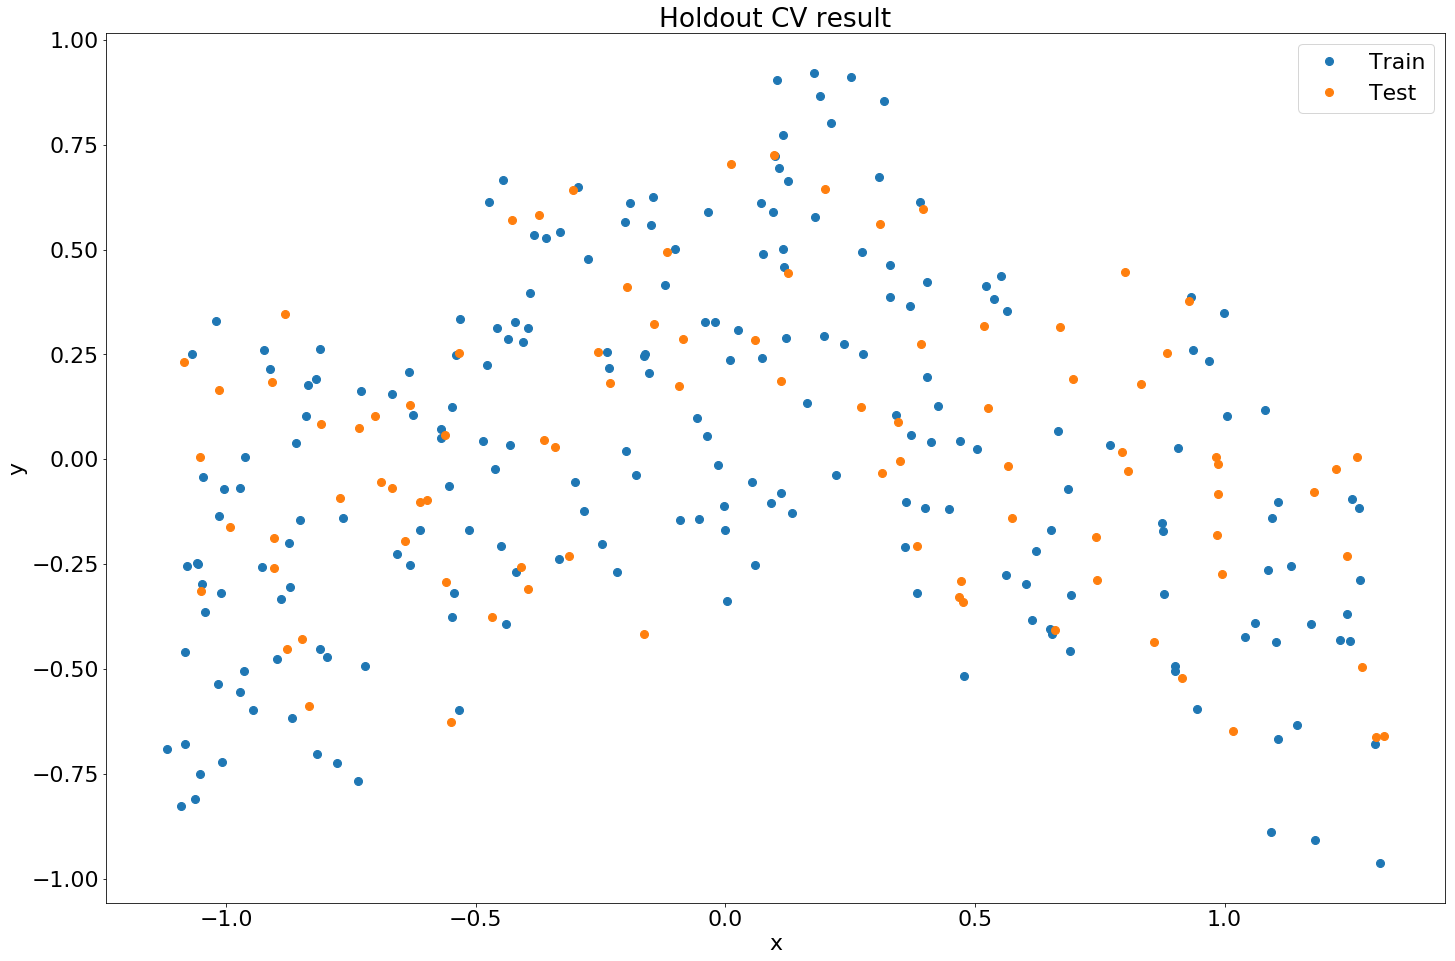

In [150]:
mean_x, mean_y = np.mean(x), np.mean(y)
s_x, s_y = np.var(x, ddof=1), np.var(y, ddof=1)

norm_x = (x - mean_x) / s_x
norm_y = (y - mean_y) / s_y
    
x_train, x_test, y_train, y_test = train_test_split(norm_x, norm_y, test_size=0.3)

fig, ax = plt.subplots(1, 1)
# normalized, splitted = ax[0], ax[1]
splitted = ax

# normalized.set_title('Normalized Data')
# normalized.set_xlabel('x')
# normalized.set_ylabel('y')
# normalized.plot(norm_x, norm_y, 'ro', markersize=8)

splitted.set_title('Holdout CV result')
splitted.set_xlabel('x')
splitted.set_ylabel('y')
splitted.plot(x_train, y_train, 'o', markersize=8, label='Train')
splitted.plot(x_test, y_test, 'o', markersize=8, label='Test')
splitted.legend()

plt.show();

## Строим модели

а) линейной регрессии;

б) LASSO-регрессии при $\lambda \approx 0$;

в) LASSO-регрессии при $\lambda \gg 0$.

In [135]:
results = []

LINR_LABEL = 'Linear Regression'
linr = lm.LinearRegression()
linr.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
results.append((LINR_LABEL, linr.intercept_, linr.coef_))

LAS0_LABEL = 'Lasso ($\\lambda \\approx 0$)'
LAMBDA_APPROX_ZERO = 0.05
las0 = lm.Lasso(alpha=LAMBDA_APPROX_ZERO)
las0.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
results.append((LAS0_LABEL, las0.intercept_, las0.coef_))


LAMBDA_GG_ZERO = 20
LAS1_LABEL = 'Lasso ($\\lambda = {}$)'.format(LAMBDA_GG_ZERO)
las1 = lm.Lasso(alpha=LAMBDA_GG_ZERO)
las1.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
results.append((LAS1_LABEL, las1.intercept_, las1.coef_))

## 1. Графики зависимости MSE моделей от параметра m (числа регрессоров в регрессионной модели)

Поскольку в данных варианта доступен только один регрессор, построить графики зависимости не представляется возможным. Покажем на графике MSE для всех трёх моделей в случае доступного единственного регрессора:

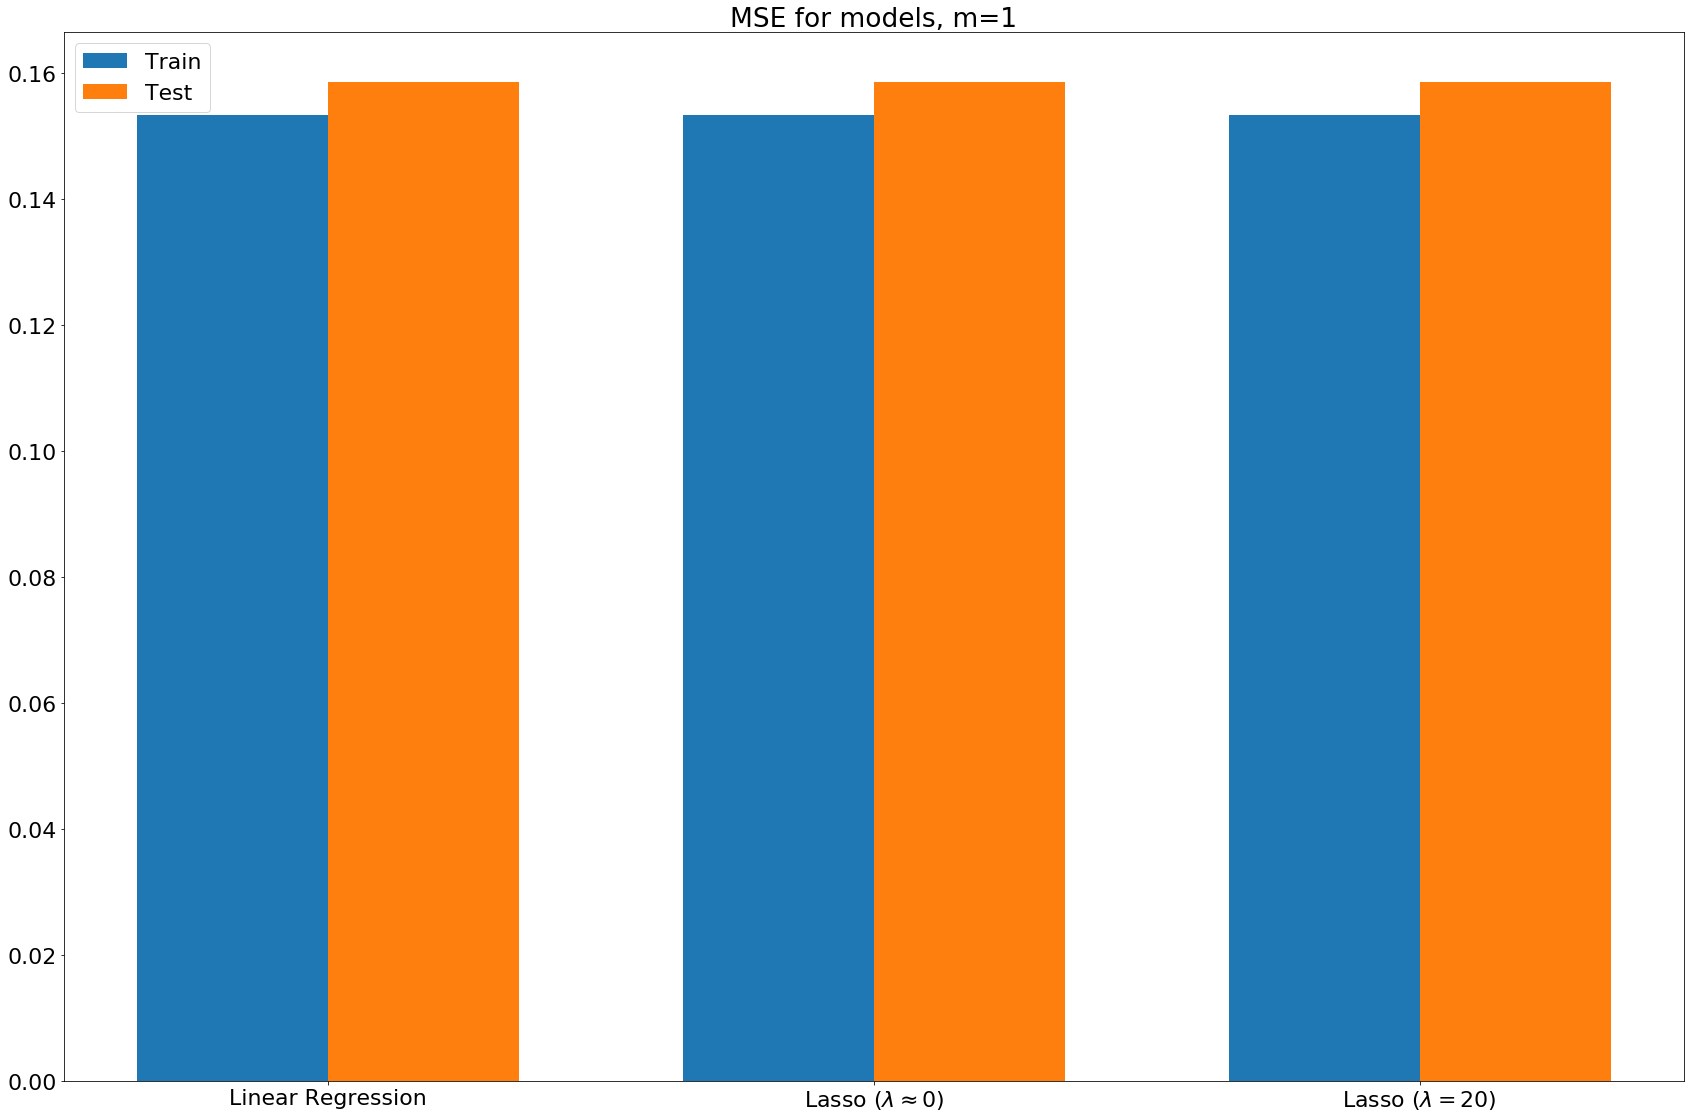

In [136]:
def mse(x, y, model):
    y_model = np.array([model.predict(np.reshape(x_i, (1, -1))) for x_i in x])
    return np.mean((y - y_model) ** 2)

def multiple_mse(x, y, *models):
    mses = np.array([mse(x, y, model) for model in models])
    return mses

mses_train = multiple_mse(x_train, y_train, linr, las0, las1)
mses_test = multiple_mse(x_test, y_test, linr, las0, las1)

bar_width = 0.35
indicies = np.arange(3)

fig, ax = plt.subplots()
ax.bar(
    indicies,
    mses_train,
    bar_width,
    label='Train'
)
ax.bar(
    indicies + bar_width,
    mses_test,
    bar_width,
    label='Test'
)
ax.set_title('MSE for models, m=1')
ax.set_xticks(indicies + bar_width / 2)
ax.set_xticklabels([LINR_LABEL, LAS0_LABEL, LAS1_LABEL])
ax.legend()

fig.tight_layout()
plt.show();

## 2. Графики выхода регрессионных моделей

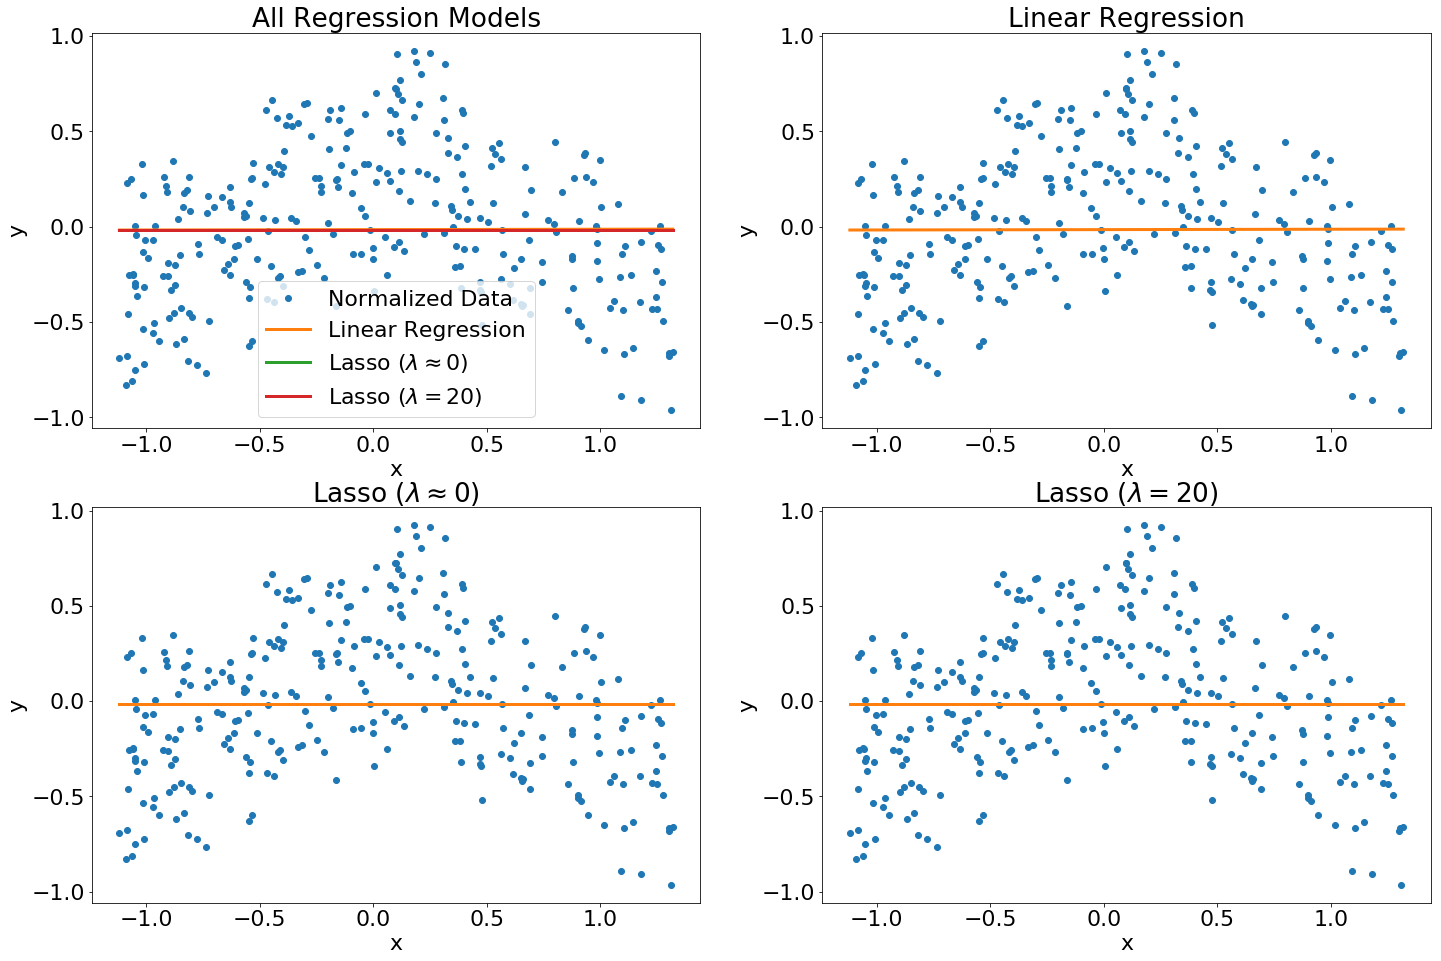

In [137]:
def line(b1, b0):
    line_x = np.array([np.min(norm_x), np.max(norm_x)])
    line_y = line_x * b1 + b0
    return line_x, line_y

def draw(i, canvas):
    name, b0, b1 = results[i]
    line_x, line_y = line(b1, b0)
    canvas.plot(line_x, line_y, label=name, lw=3)

fig, ax = plt.subplots(2, 2)
all_in_one = ax[0][0]
singles = [ax[0][1], ax[1][0], ax[1][1]]

all_in_one.set_title('All Regression Models')
all_in_one.set_xlabel('x')
all_in_one.set_ylabel('y')
all_in_one.plot(norm_x, norm_y, 'o', label='Normalized Data', markersize=6)

for i in range(3):
    draw(i, all_in_one)

all_in_one.legend()

for i in range(3):
    canvas = singles[i]
    canvas.set_title(results[i][0])
    canvas.set_xlabel('x')
    canvas.set_ylabel('y')
    canvas.plot(norm_x, norm_y, 'o', label='Normalized Data', markersize=6)
    draw(i, canvas)

## 3. Графики зависимости значений коэффициентов регрессионной модели от параметра $\lambda$

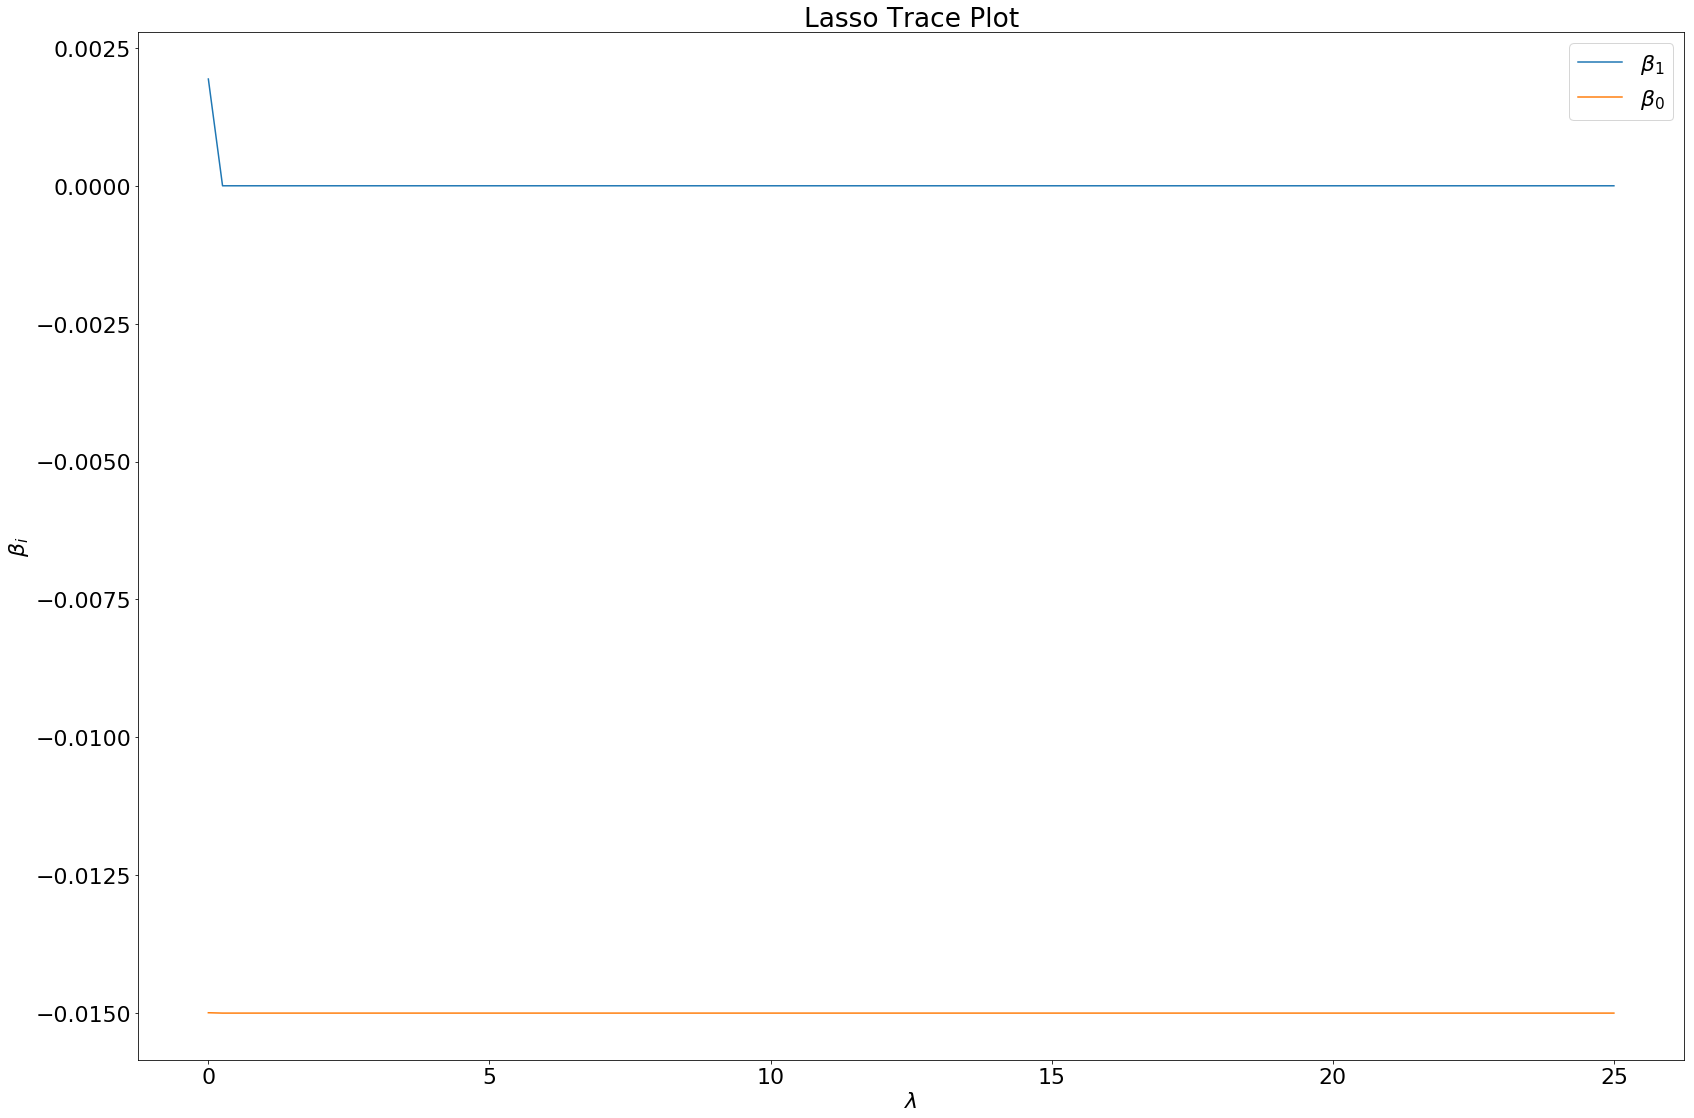

In [139]:
ls = np.linspace(0, 25, 100)

def get_coeffs(l):
    if l == 0:
        model = lm.LinearRegression()
    else:
        model = lm.Lasso(alpha=l)
    model.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
    return model.intercept_, model.coef_

coeffs = [get_coeffs(l) for l in ls]

b0s = [c[0] for c in coeffs]
b1s = [c[1] for c in coeffs]

fig, ax = plt.subplots()

ax.plot(ls, b1s, label='$\\beta_1$')
ax.plot(ls, b0s, label='$\\beta_0$')

ax.set_title('Lasso Trace Plot')
ax.set_xlabel('$\\lambda$')
ax.set_ylabel('$\\beta_i$')

ax.legend()

fig.tight_layout()
plt.show();

## 4. Дисперсия отклика модели

In [152]:
N = 50

def variance(model, x_train, y_train, x_test, y_test):
    model.fit(np.reshape(x_train, (len(x_train), 1)), y_train)
    y_model_train = model.predict(np.reshape(x_train, (len(x_train), 1)))
    y_model_test = model.predict(np.reshape(x_test, (len(x_test), 1)))
    var_train, var_test = np.var(y_model_train), np.var(y_model_test)
    return var_train, var_test

vars_linr = []
vars_las0 = []
vars_las1 = []

for i in range(N):
    x_train, x_test, y_train, y_test = train_test_split(norm_x, norm_y, test_size=0.3)
    
    models = [
        lm.LinearRegression(),
        lm.Lasso(LAMBDA_APPROX_ZERO),
        lm.Lasso(LAMBDA_GG_ZERO)
    ]
    
    vars_linr.append(variance(lm.LinearRegression(),        x_train, y_train, x_test, y_test))
    vars_las0.append(variance(lm.Lasso(LAMBDA_APPROX_ZERO), x_train, y_train, x_test, y_test))
    vars_las1.append(variance(lm.Lasso(LAMBDA_GG_ZERO),     x_train, y_train, x_test, y_test))

arrs = [vars_linr, vars_las0, vars_las1]
labels = [LINR_LABEL, LAS0_LABEL, LAS1_LABEL]

def draw_hist(i, bins='auto'):
    fig, ax = plt.subplots()

    arr = arrs[i]
    label = labels[i]
    var_train = [v[0] for v in arr]
    var_test  = [v[1] for v in arr]

    ax.hist(var_train, bins, label='Train', alpha=0.6)
    ax.hist(var_test, bins, label='Test', alpha=0.6)

    ax.set_title('$D[\\tilde{y}]$ for ' + label)
    ax.legend()

    plt.show();

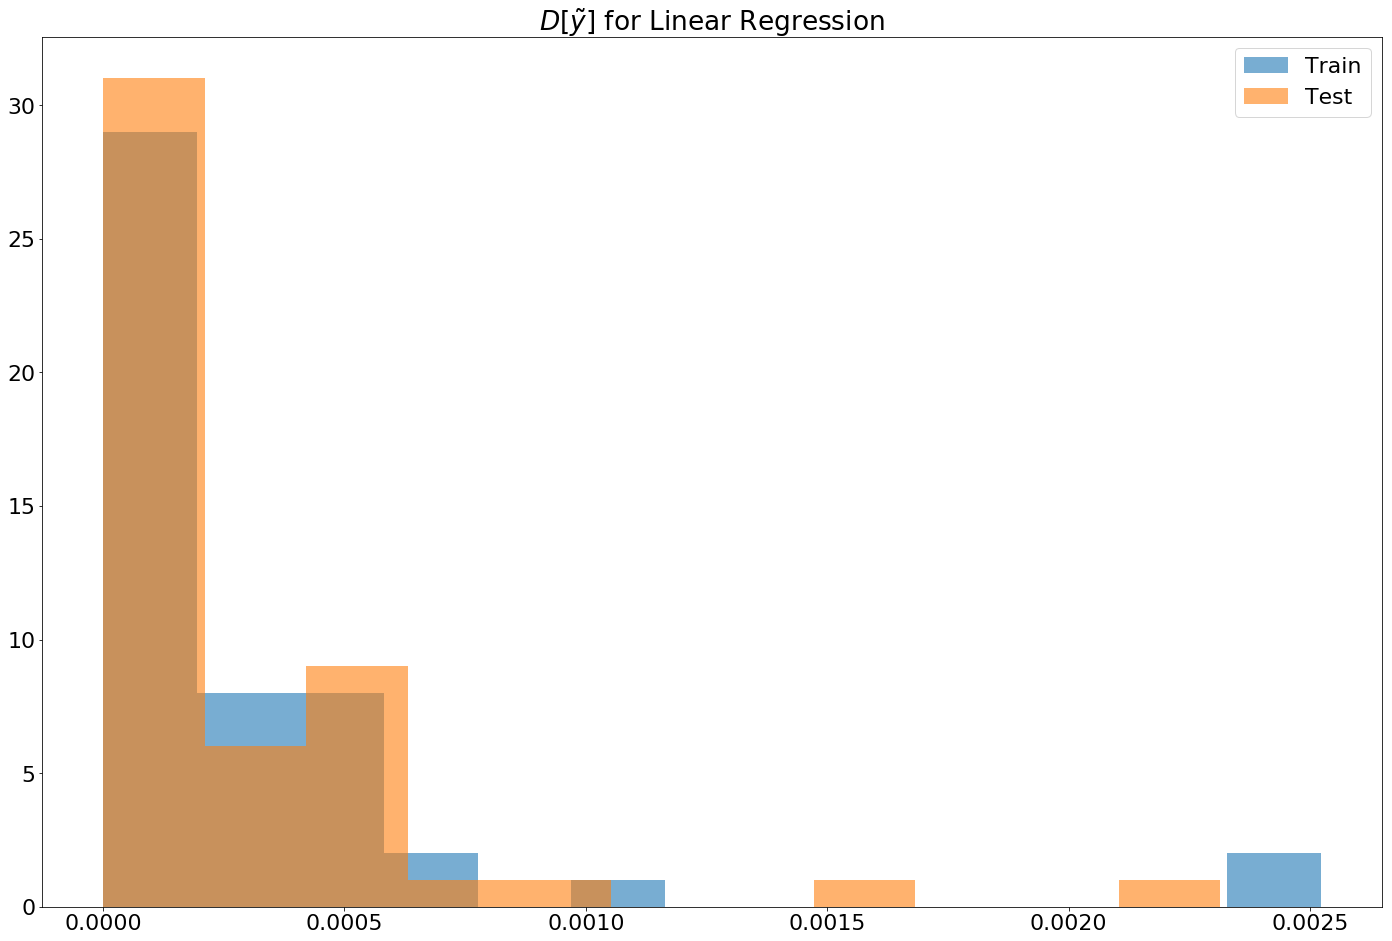

In [142]:
draw_hist(0)

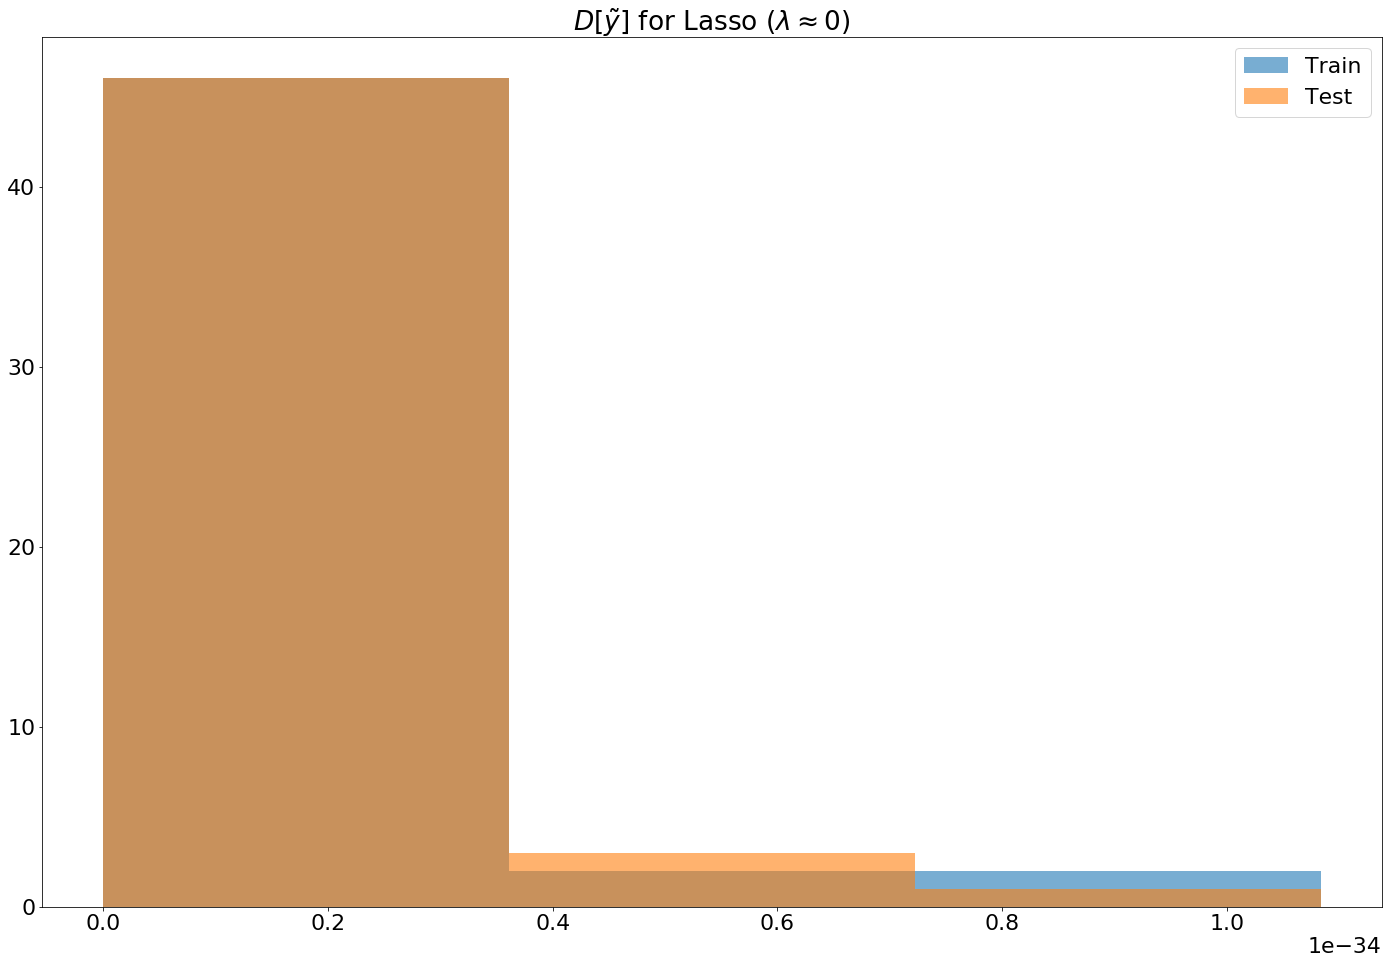

In [155]:
draw_hist(1, 3)

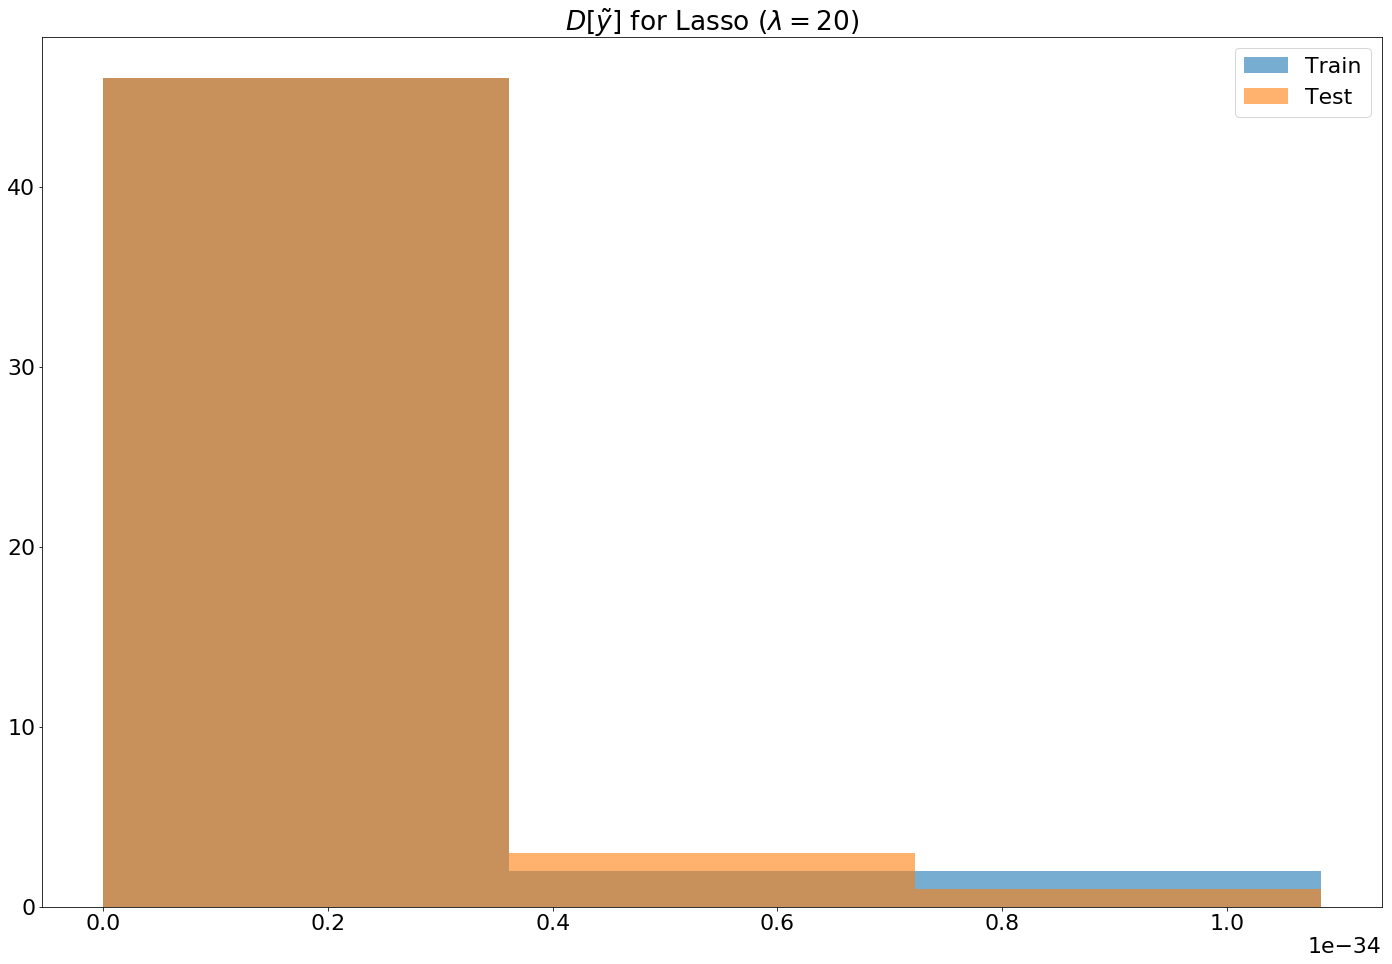

In [154]:
draw_hist(2, 3)

## 5. Исследование регрессионных остатков

In [145]:
def get_es(model, x, y):
    y_model = model.predict(np.reshape(x, (len(x), 1)))
    return y - y_model

def draw_es_for_model(model, label):
    x_ind_sorted = np.argsort(norm_x)
    y_ind_sorted = np.argsort(norm_y)

    es = get_es(model, norm_x, norm_y)

    print('M[e] = {} for {}'.format(np.mean(es), label))

    fig, ax = plt.subplots(1, 2)

    ax[0].set_title('Зависимость e(x) для {}'.format(label))
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('e')
    ax[0].plot(norm_x[x_ind_sorted], es[x_ind_sorted])

    ax[1].set_title('Зависимость e(y) для {}'.format(label))
    ax[1].set_xlabel('y')
    ax[1].set_ylabel('e')
    ax[1].plot(norm_y[y_ind_sorted], es[y_ind_sorted])

    plt.show();

M[e] = 0.014993649945693258 for Linear Regression


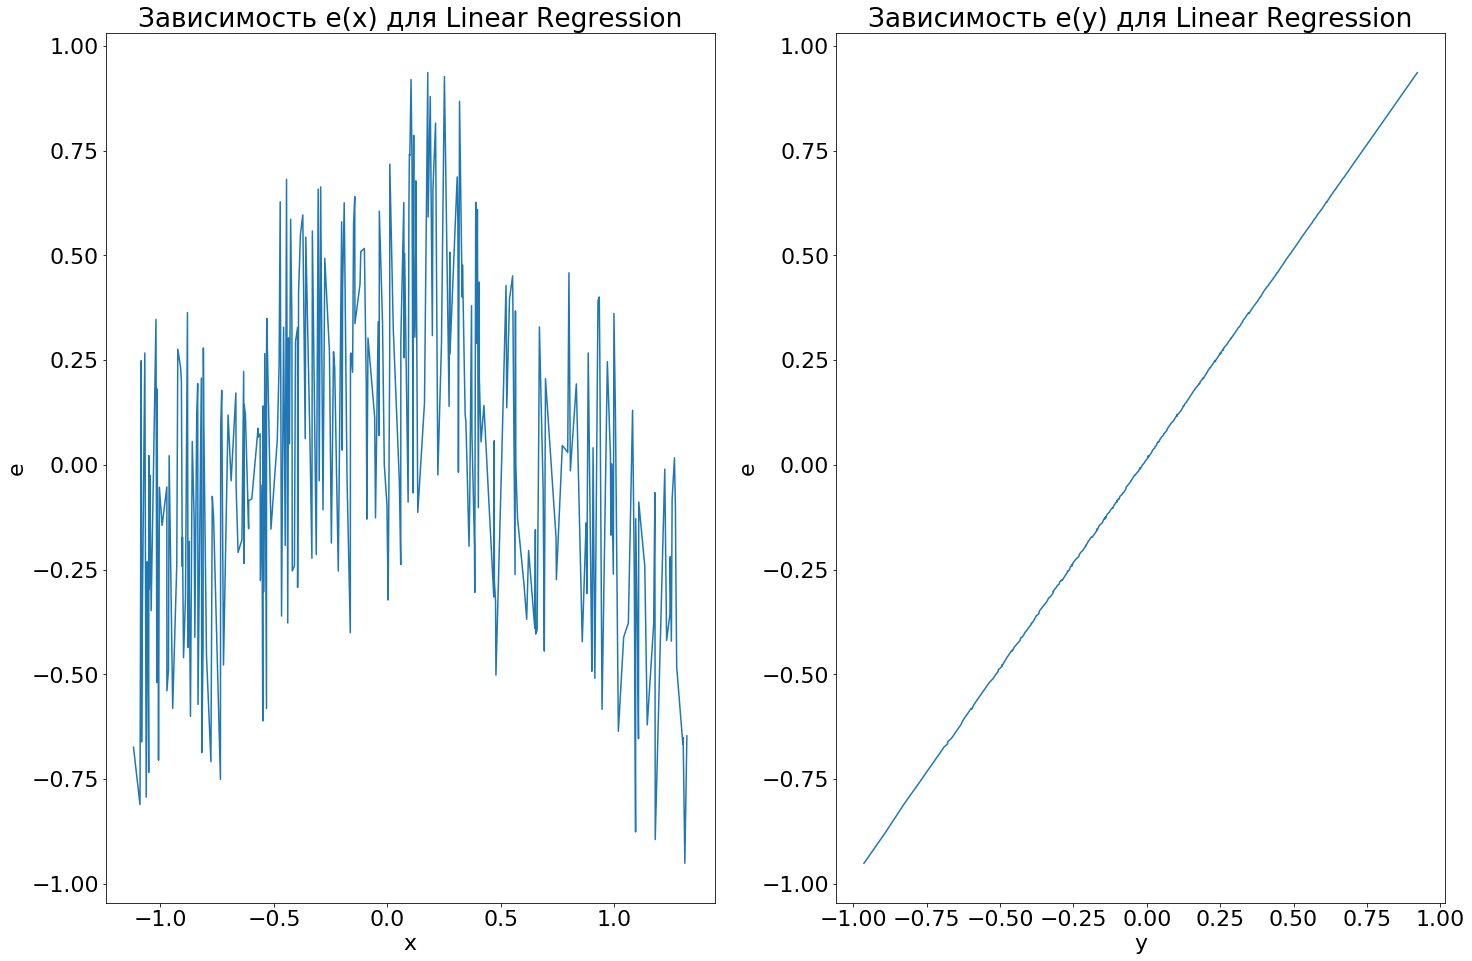

In [146]:
draw_es_for_model(linr, LINR_LABEL)

M[e] = 0.015000075037732919 for Lasso ($\lambda \approx 0$)


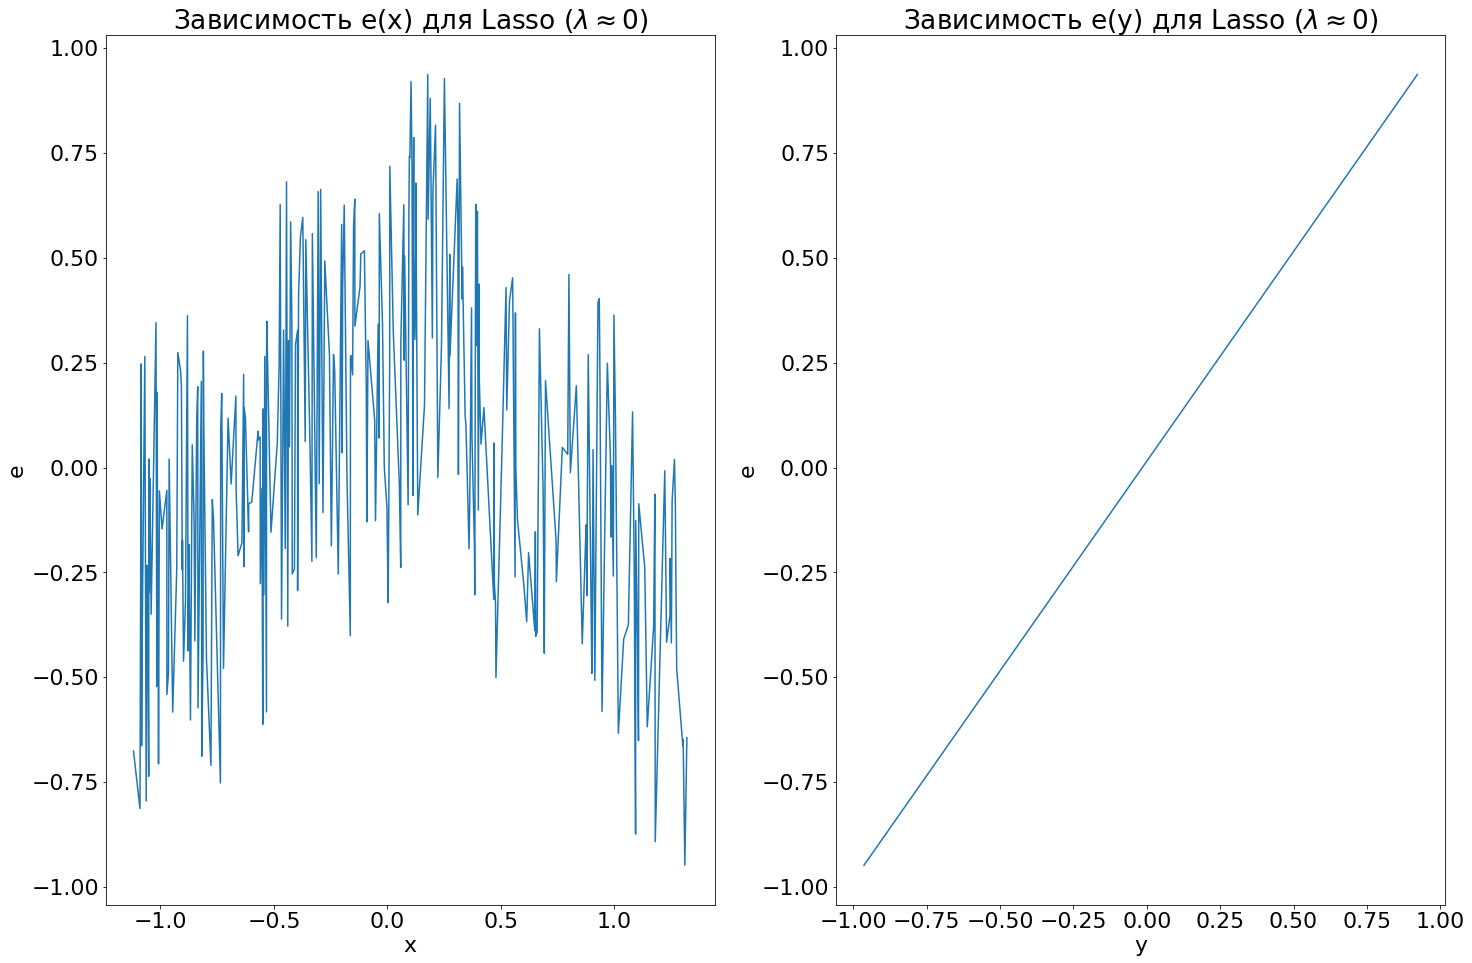

In [147]:
draw_es_for_model(las0, LAS0_LABEL)

M[e] = 0.015000075037732919 for Lasso ($\lambda = 20$)


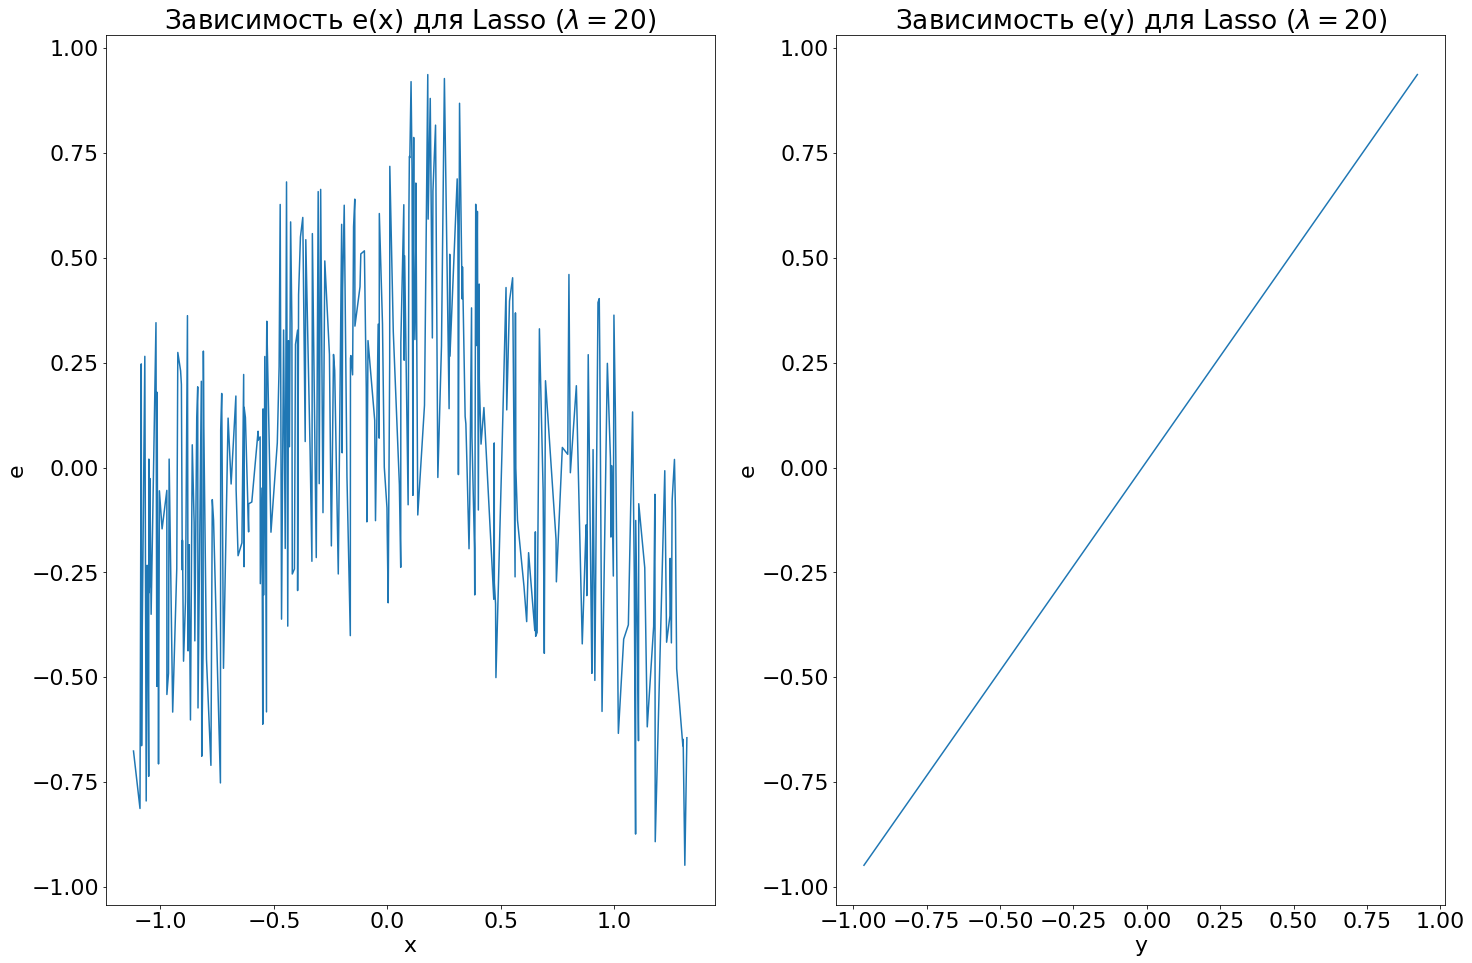

In [148]:
draw_es_for_model(las1, LAS1_LABEL)